In [40]:
%cd /content/drive/MyDrive/EECS 545/final/EECS545-Final-Project
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
# import xgboost2
import seaborn as sns

# plt.rcParams["figure.figsize"] = (10,8)
# plt.style.library['seaborn-whitegrid']
# plt.style.use('seaborn-whitegrid')
# plt.rcParams.update({'font.size': 16})

/content/drive/MyDrive/EECS 545/final/EECS545-Final-Project


In [41]:
# import dataframes
X_test = pd.read_csv('./data/x_test_adult.csv')
y_train = pd.read_csv('./data/y_train_adult.csv')
y_test = pd.read_csv('./data/y_test_adult.csv')
X_train = pd.read_csv('./data/x_train_adult.csv')
print(X_train.shape)
print(y_train.values.shape)
print(y_train.columns)

(26048, 14)
(26048, 3)
Index(['Unnamed: 0', 'id', 'income'], dtype='object')


In [43]:
import numpy as np
from IPython.core.debugger import set_trace
import time
import matplotlib.pyplot as plt
class Node:
    split_list=[]
    gain_list=[]
    cover_list=[]
    def __init__(self, x, samples, grad, hess, feature_sel=0.8 , min_num_leaf=5, min_child_weight=1, depth=0, max_depth=10, reg=1, gamma=1):
        self.x = x
        self.grad = grad
        self.hess = hess
        self.samples = samples 
        self.depth = depth
        self.min_num_leaf = min_num_leaf
        self.reg = reg
        self.gamma  = gamma
        self.min_child_weight = min_child_weight
        self.feature_sel = feature_sel
        self.max_depth = max_depth
        self.n_samples = len(samples)
        self.n_features = self.x.shape[1]
        self.subsampled_features = np.random.choice(np.arange(self.n_features), int(np.round(self.feature_sel * self.n_features)))
        self.val = -np.sum(self.grad[self.samples])/(np.sum(self.hess[self.samples]) + self.reg)
        self.rhs = None
        self.lhs = None
        self.score = float('-inf')
    def compute_gamma(self, gradient, hessian):
        return -np.sum(gradient)/(np.sum(hessian) + self.reg)
        
    def grow_tree(self):
        for feature in self.subsampled_features:
            self.find_greedy_split(feature)
        if not self.is_leaf:
            x = self.x[self.samples , self.split_feature]
            lhs = np.nonzero(x <= self.split_val)[0]
            rhs = np.nonzero(x > self.split_val)[0]
            self.lhs = Node(self.x, self.samples[lhs], self.grad, self.hess, self.feature_sel, self.min_num_leaf, self.min_child_weight, self.depth+1, self.max_depth, self.reg, self.gamma)
            self.rhs = Node(self.x, self.samples[rhs], self.grad, self.hess, self.feature_sel, self.min_num_leaf, self.min_child_weight, self.depth+1, self.max_depth, self.reg, self.gamma)
            Node.split_list.append(self.split_feature) ## feature index each split 
            Node.gain_list.append(self.get_gain(lhs, rhs)) ## gain each split
            Node.cover_list.append(len(self.samples)) ## samples in node before each split
            self.lhs.grow_tree()
            self.rhs.grow_tree()

    def find_greedy_split(self, feature):
        x = self.x[self.samples, feature]
        
        for i in range(self.n_samples):
            lhs = x <= x[i]
            rhs = x > x[i]
            
            lhs_idxs = np.nonzero(x <= x[i])[0]
            rhs_idxs = np.nonzero(x > x[i])[0]

            # check num samples on both sides of split
            if (rhs.sum() > self.min_num_leaf) and (lhs.sum() > self.min_num_leaf):

                # check purity score
                if (self.hess[lhs_idxs].sum() > self.min_child_weight) and (self.hess[rhs_idxs].sum() > self.min_child_weight):

                    curr_score = self.get_gain(lhs, rhs)
                    if curr_score > self.score: 
                        self.split_feature = feature
                        self.score = curr_score
                        self.split_val = x[i] 
            
                
    def get_gain(self, lhs, rhs):
        gradient = self.grad[self.samples]
        hessian  = self.hess[self.samples]
        
        gradl = gradient[lhs].sum()
        hessl  = hessian[lhs].sum()
        
        gradr = gradient[rhs].sum()
        hessr  = hessian[rhs].sum()

        return 0.5 * (gradl**2/(hessl + self.reg) + gradr**2/(hessr + self.reg) - (gradl + gradr)**2/(hessr + hessl + self.reg)) - self.gamma
                
    @property
    def is_leaf(self):
        return self.score == float('-inf') or self.depth >= self.max_depth                

    def predict(self, x):
        pred = np.zeros(x.shape[0])
        for sample in range(x.shape[0]):
            pred[sample] = self.predict_sample(x[sample,:])

        return pred
    
    def predict_sample(self, sample):
        if self.is_leaf:
            return self.val

        if sample[self.split_feature] <= self.split_val:
            next_node = self.lhs
        else:
            next_node = self.rhs

        return next_node.predict_sample(sample)

    
class XGBoostTree:
    def fit(self, x, grad, hess, feature_sel, min_num_leaf, min_child_weight, max_depth, reg, gamma):
        self.tree = Node(x, np.array(np.arange(x.shape[0])), grad, hess, feature_sel, min_num_leaf, min_child_weight, depth=0, max_depth=max_depth, reg=reg, gamma=gamma)
        self.tree.grow_tree()
        return self
    def predict(self, x):
        return self.tree.predict(x)
   
   
class XGBoostClassifier:
    def __init__(self):
        self.dec_trees = []
    
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    # first order gradient logLoss
    def grad(self, preds, labels):
        preds = self.sigmoid(preds)
        return preds - labels
    
    # second order gradient logLoss
    def hess(self, preds):
        preds = self.sigmoid(preds)
        return preds * (1 - preds)
    
    @staticmethod
    def log_odds(column):
        binary_yes = np.count_nonzero(column == 1)
        binary_no  = np.count_nonzero(column == 0)
        return(np.log(binary_yes/binary_no))
    
    def fit(self, x, y, boosting_rounds=5, feature_sel=0.8, min_num_leaf=5, min_child_weight=1, max_depth=5, lr=0.4, reg=1.5, gamma=1):
        self.x, self.y = x, y
        #set_trace()
        self.max_depth = max_depth
        self.feature_sel = feature_sel
        self.min_child_weight = min_child_weight 
        self.min_num_leaf = min_num_leaf
        self.lr = lr
        self.boosting_rounds = boosting_rounds 
        self.reg = reg
        self.gamma = gamma
        self.base_pred = np.full((x.shape[0], 1), 1).flatten().astype('float64')
        for booster in range(self.boosting_rounds):
            print('boosting round {}'.format(booster))
            Grad = self.grad(self.base_pred, self.y)
            Hess = self.hess(self.base_pred)
            boosting_tree = XGBoostTree().fit(x, grad=Grad, hess=Hess, feature_sel=self.feature_sel, min_num_leaf=self.min_num_leaf, min_child_weight=self.min_child_weight, max_depth=self.max_depth, reg=self.reg, gamma=self.gamma)
            #print('inclassifier',boosting_tree.tree.split_feature)
            self.base_pred += self.lr * boosting_tree.predict(self.x)
            self.dec_trees.append(boosting_tree)
    
    def predict(self, X):
        pred = np.zeros(X.shape[0])
        for tree in self.dec_trees:
            pred += self.lr * tree.predict(X) 
        
        predicted_probas = self.sigmoid(np.full((X.shape[0], 1), 1).flatten().astype('float64') + pred)
        preds = np.where(predicted_probas > np.mean(predicted_probas), 1, 0)
        return preds
    def cal_feature_importance(self): 
        fe_imp_split = dict()
        fe_imp_gain = dict()
        fe_imp_cover = dict()
        func_shift=lambda x: x-min(x) # shift func for gain value
        Node.gain_list=func_shift(Node.gain_list)
        for i in range(self.x.shape[1]): 
          fe_imp_split[i] = 0
          fe_imp_gain[i] = 0
          fe_imp_cover[i] = 0  
        for i in range(len(Node.split_list)):
          index=Node.split_list[i]
          fe_imp_split[index] = fe_imp_split[index] + 1
          fe_imp_gain[index] = fe_imp_gain[index] + Node.gain_list[i]
          fe_imp_cover[index] = fe_imp_cover[index] + Node.cover_list[i]
          # print(index)
        return fe_imp_split,fe_imp_gain,fe_imp_cover # dict:{key=feature_index,value=feature_importance}
    def fe_index(self,mode):   # 0: split 1: gain 2: cover
        dict_fe = self.cal_feature_importance()
        return np.flip(np.argsort(list(dict_fe[mode].values()))) # index with ascending order sorted by feature importance
    def fe_imp_plot(self,mode,name_list): # name_list: array of feature names
        plt.figure(figsize=(15,10),dpi=400)
        fontsize={'fontsize':20}
        title_list=['Split','Gain','Cover']
        title=title_list[mode]
        title=f'Feature Importance ({title})'
        plt.xlabel('feature importance',fontdict=fontsize)
        plt.title(title,fontdict=fontsize)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        imp_dict=self.cal_feature_importance()
        ind=np.argsort(list(imp_dict[mode].values()))
        plt.barh(np.array(name_list[ind]), np.array(list(imp_dict[mode].values()))[ind])
        plt.savefig(f'_{title}',dpi=400)
        return
model_adult = XGBoostClassifier()
start = time.time()
model_adult.fit(X_train.values, y_train['income'].values,
        reg = 0.17032894478550822,
        gamma = 2.710989236548378,
        feature_sel = 0.6272659519889423,
        max_depth = 3,
        min_child_weight = 1.1642516038489912,
        min_num_leaf = 3,
        boosting_rounds = 2,
        lr = 0.4840302929456972)
end = time.time()
print('our model time: {}'.format(end-start))
name_list=list(X_train.columns.values)
     


boosting round 0
boosting round 1
our model time: 810.7289237976074


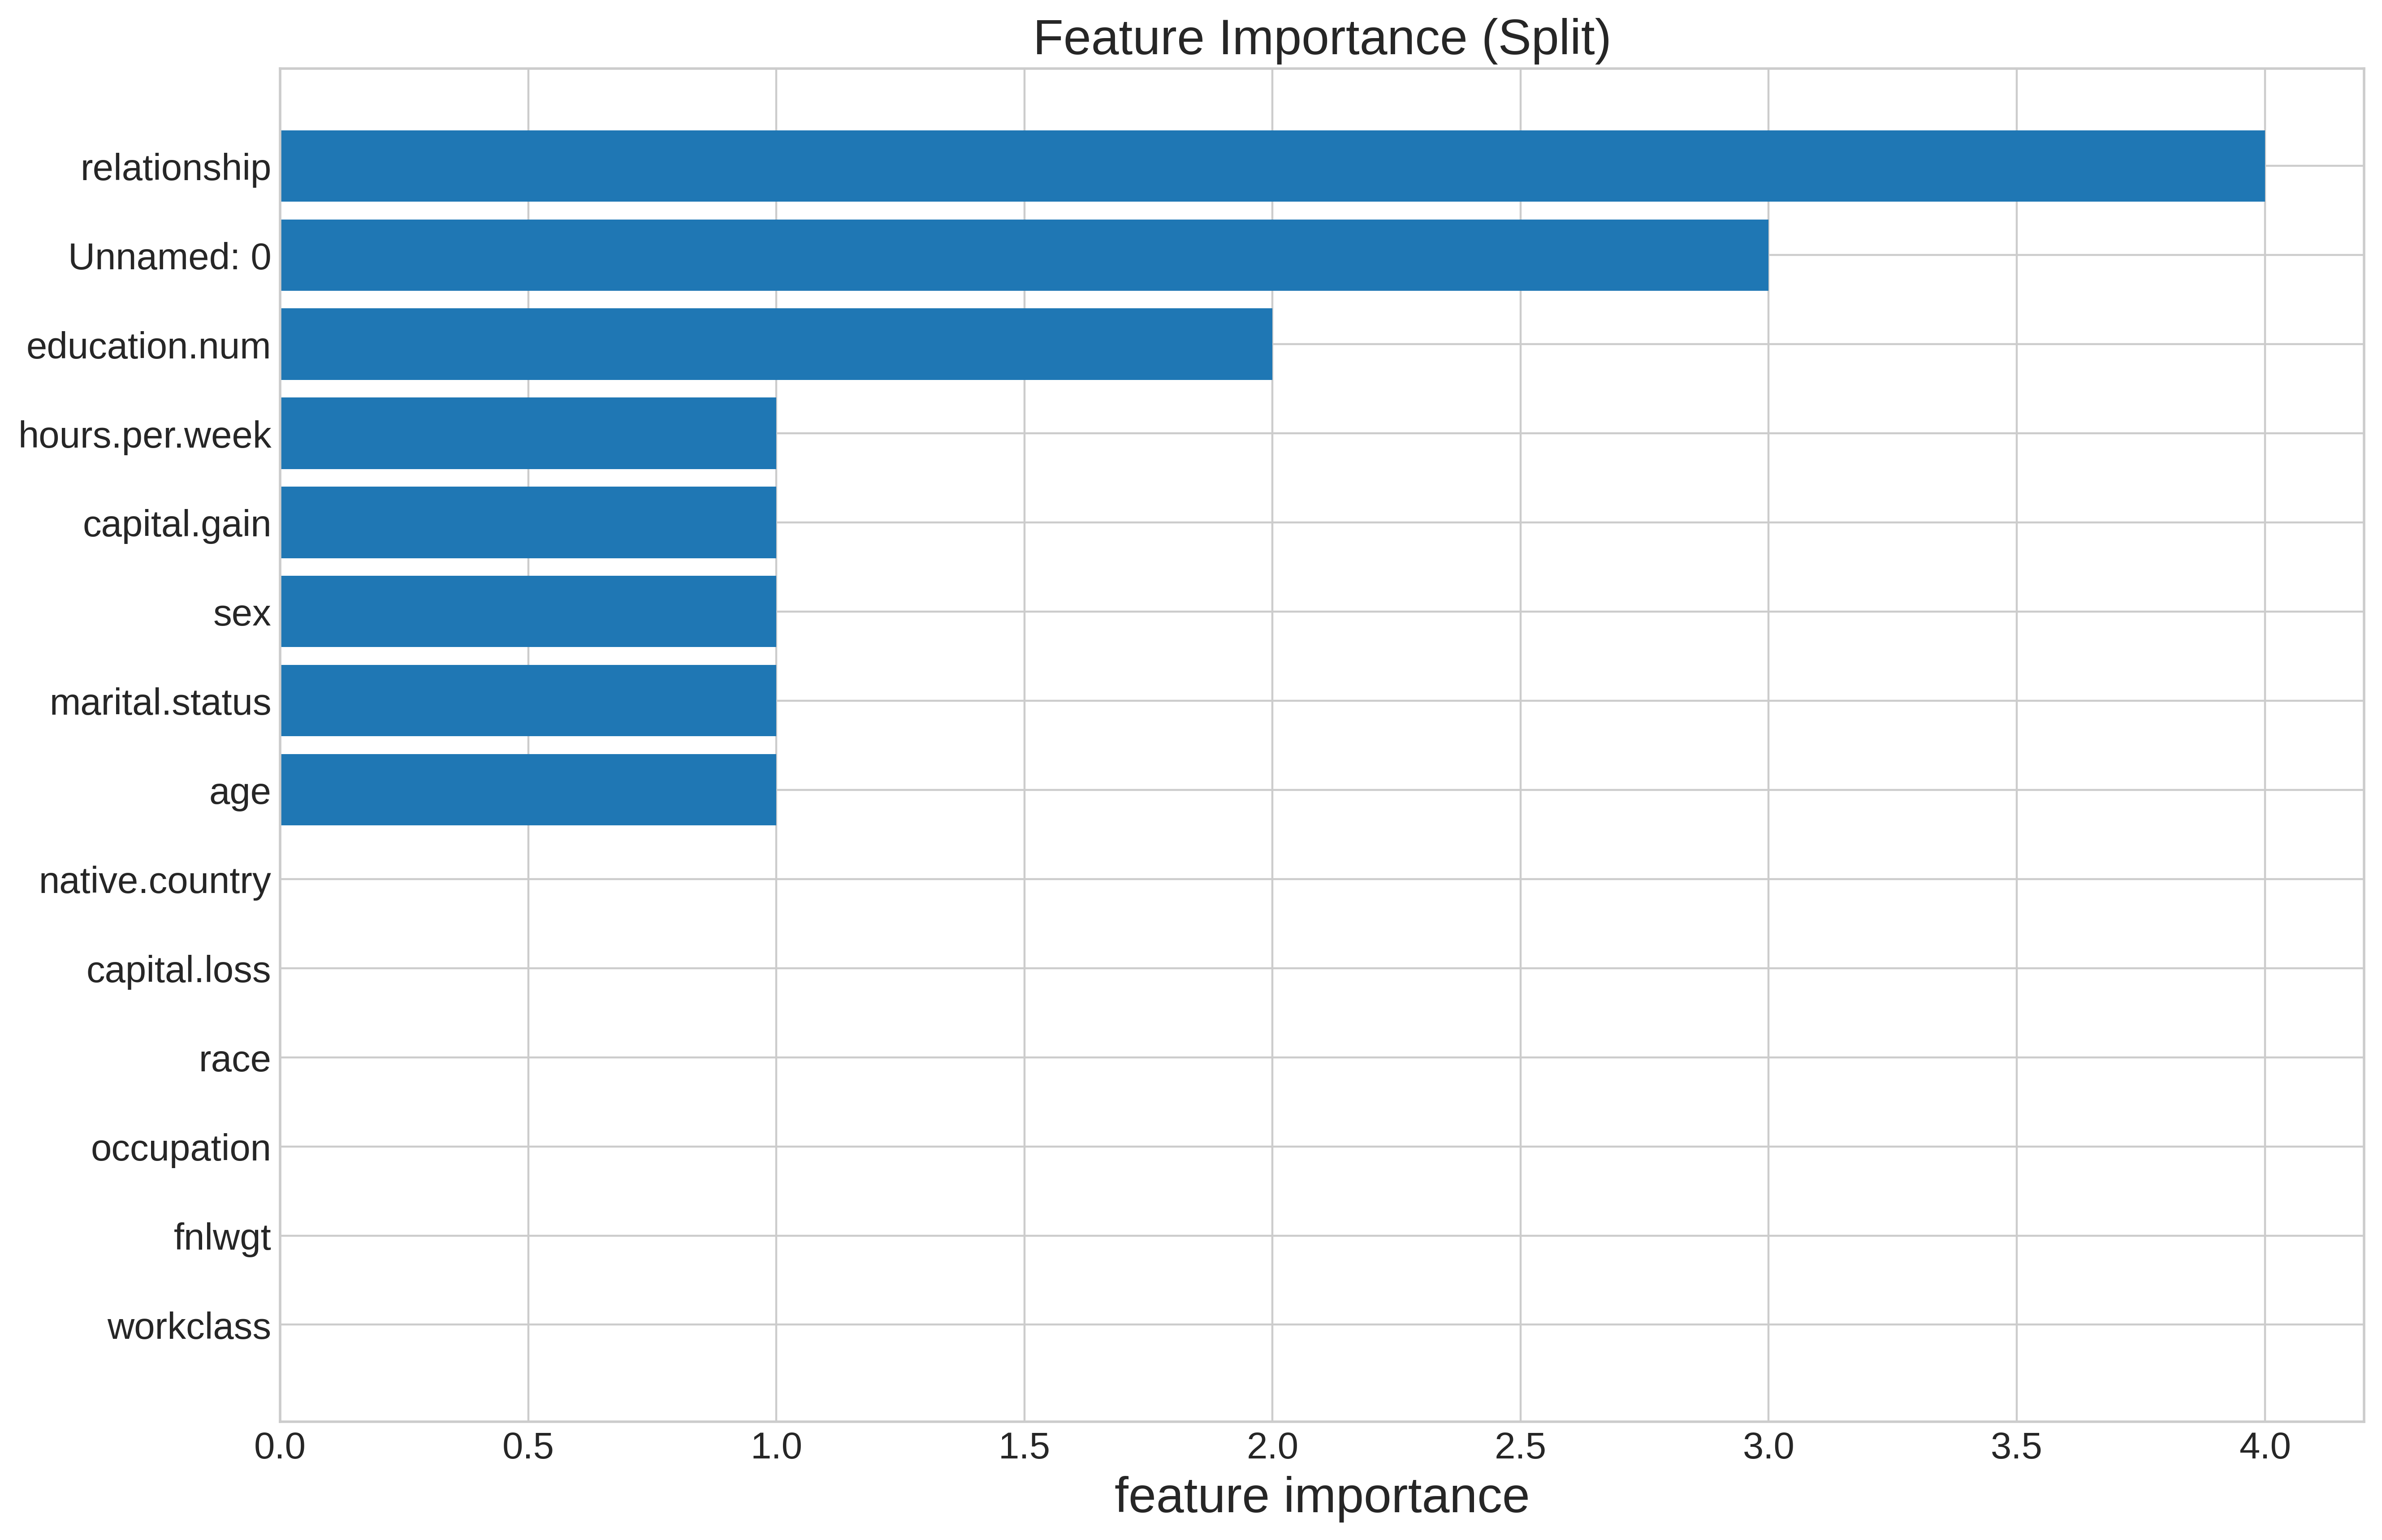

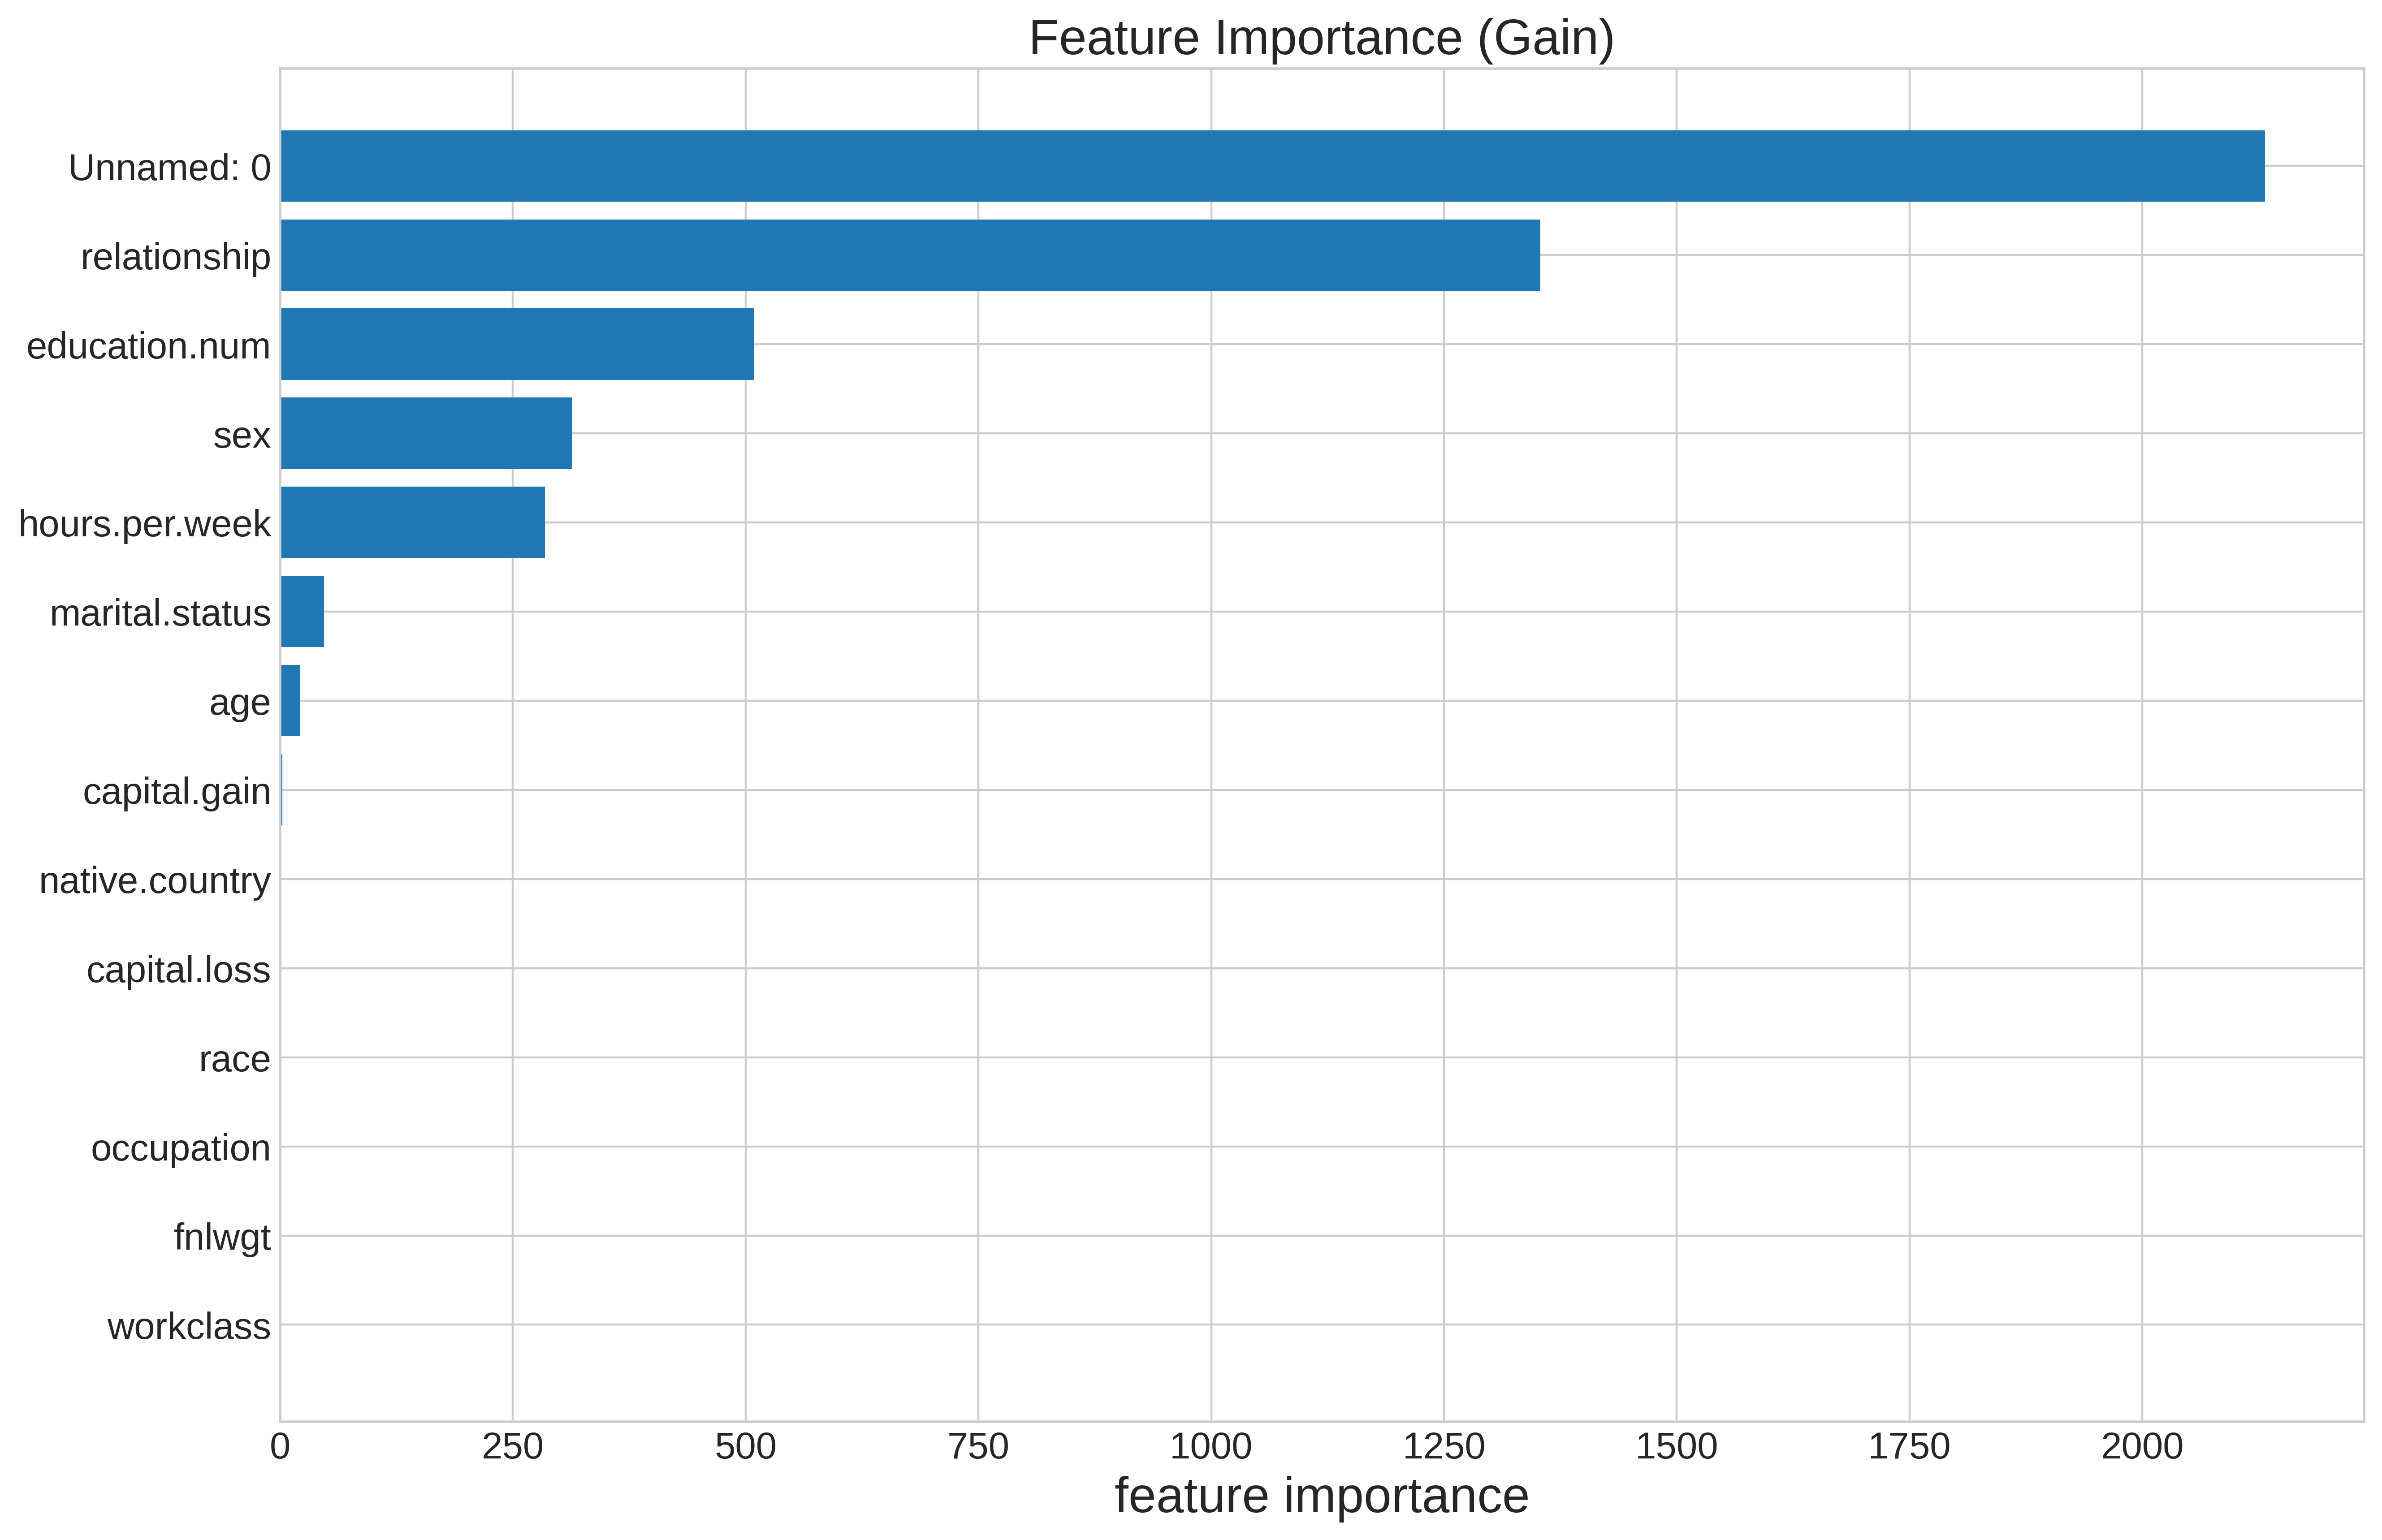

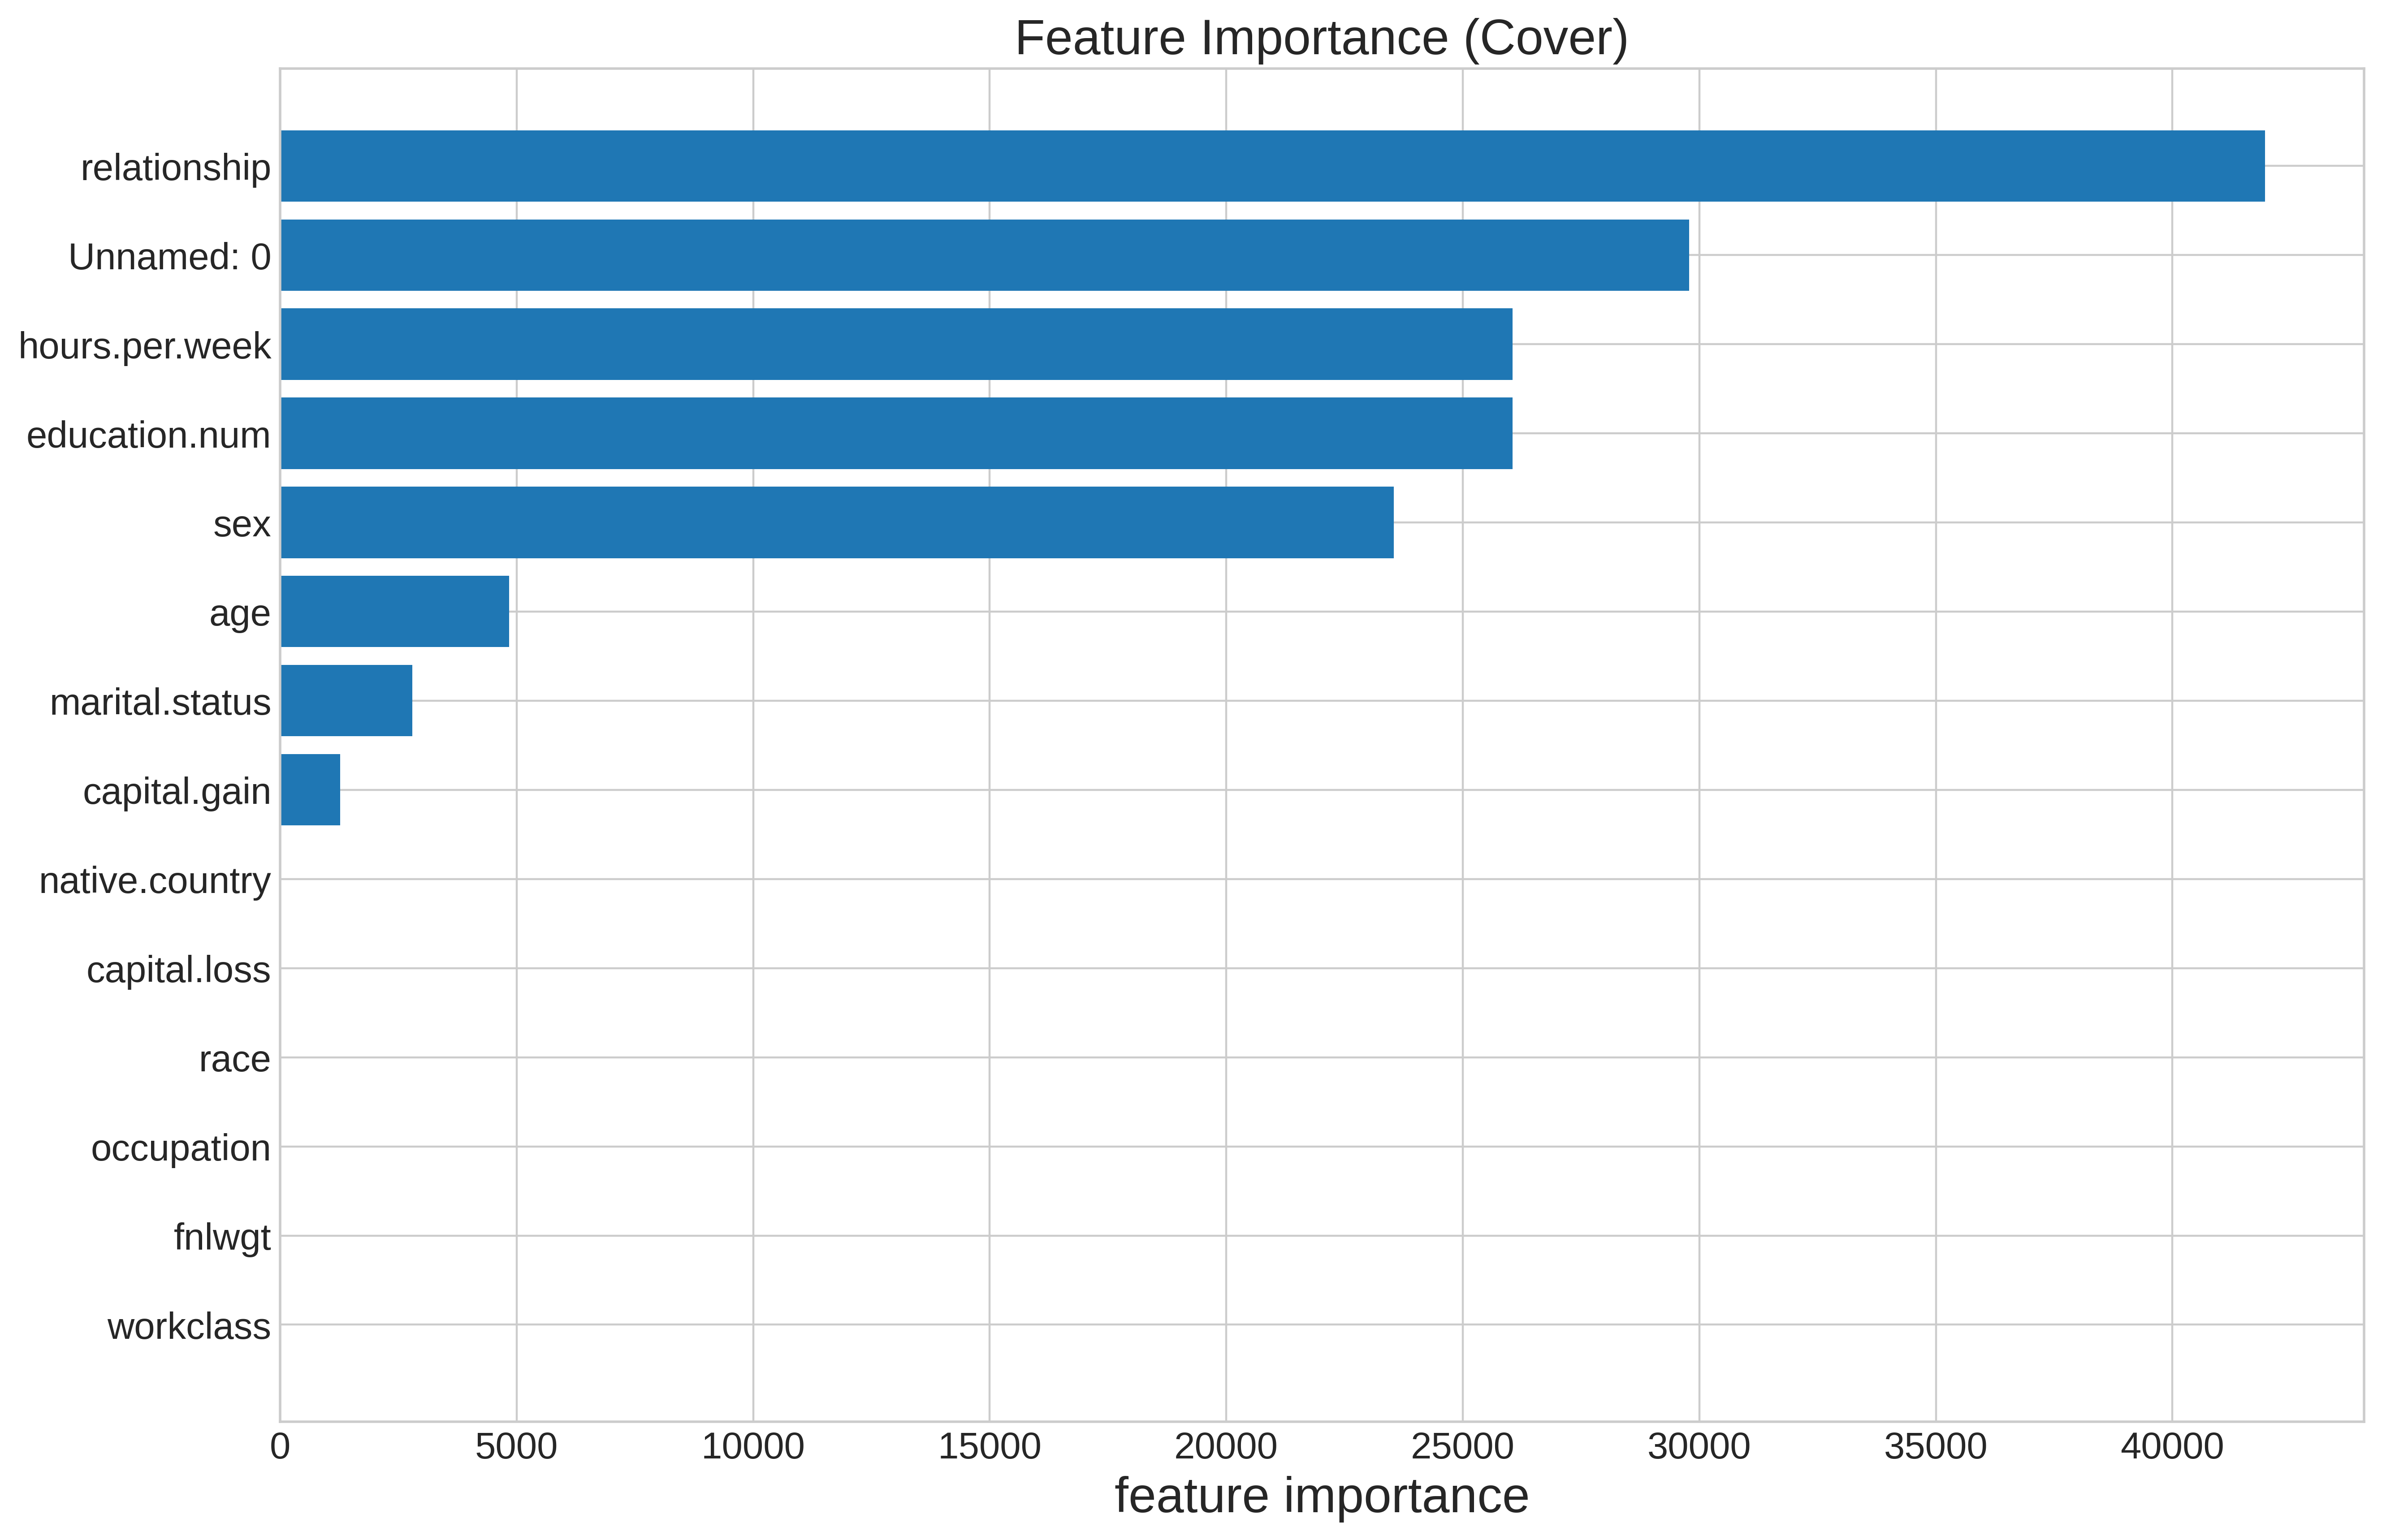

In [50]:
# plot feature importance
for i in range(0,3):
  model_adult.fe_imp_plot(i,np.array(name_list))